In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest,chi2

# With 6 Birds - Modeling

In [2]:
with open('df_6birds.pkl', ) as picklefile:
    df_allbirds = pickle.load(picklefile)

In [3]:
df_allbirds.replace(['bird0','bird1','bird2','bird3','bird4','bird5','nan'], ['great antshrike', 'dusky antbird', 'barred antshrike', 'northern cardinal', 'american robin', 'house finch', '0'], inplace=True)
df_allbirds.head()

,wav,bird,1 kHz,2 kHz,3 kHz,4 kHz,5 kHz,6 kHz,7 kHz,8 kHz,...,MFCC 5,MFCC 6,MFCC 7,MFCC 8,MFCC 9,MFCC 10,MFCC 11,MFCC 12,MFCC 13,Max Frq. Hz
0,0225 American Robin.wav,american robin,0.00660811337607,0.00586052709567,0.114964782126,0.0447805974047,0.00338685235494,0.000903604240303,0.000830894963305,0.000684011153386,...,-32.035849844,-32.6002993345,-32.3846143193,-31.2138321206,-31.0443985972,-31.7698419527,-34.1987718029,-32.8585805204,-32.4790001388,2791.19939804
1,20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-...,american robin,0.00303052147582,0.00180709906578,0.0767300097198,0.0203860302409,0.00501422174475,0.00216170303658,0.000885244763049,0.000813158948617,...,-10.800402514,-10.8371940576,-12.4238394539,-8.31852289835,-7.35538114801,-9.12617747973,-12.8096573365,-13.7758559916,-13.5522468673,2654.26540375
2,20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-...,american robin,0.0026542594461,0.00190433208335,0.083328789534,0.0228187588581,0.0044124784794,0.00155856531937,0.000963062984715,0.00089685600878,...,-9.802308158,-11.2587251851,-12.2084366139,-13.7176464205,-12.0282096711,-12.4146472858,-11.310868484,-12.0142006754,-14.3785565767,2699.43237305
3,American Robin2011-5-26-1.wav,american robin,0.00364826030215,0.0280566702363,0.19708527077,0.138327212499,0.106067529007,0.0930323410934,0.141180400206,0.0907608752329,...,-28.1384569357,-26.0265825772,-28.0376316297,-29.3626388869,-30.5180233899,-31.3250014385,-29.8422178177,-30.7707380243,-31.1605729096,2765.35892487
4,AmericanRobin2.wav,american robin,0.00410372242442,0.0113336155918,0.0849610471753,0.148842569192,0.0508337411103,0.0297377597695,0.0128532109995,0.0062949810503,...,-40.0275450104,-39.4573350638,-40.1286220575,-40.8308214538,-40.9981361101,-40.9944714751,-40.3474120285,-40.0149242049,-39.9993980443,3059.58366394


In [4]:
# trying all features
X = df_allbirds[df_allbirds.columns[2:]]
y = df_allbirds['bird']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.33, 
                                   random_state=4)

In [5]:
clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print accuracy_score(y_test, pred)

0.24358974359


In [6]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print accuracy_score(y_test, pred)


0.602564102564


In [7]:
confusion_matrix(y_test, pred)

array([[ 8,  0,  0,  0,  2,  1],
       [ 0,  5, 10,  1,  0,  1],
       [ 1,  0, 16,  0,  0,  2],
       [ 6,  0,  0,  5,  0,  1],
       [ 0,  0,  0,  0,  3,  2],
       [ 1,  0,  0,  1,  2, 10]])

In [8]:
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print accuracy_score(y_test, pred)

0.397435897436


In [9]:
baseline = [y_test.value_counts().idxmax()]*len(y_test)

In [10]:
print accuracy_score(y_test, baseline)

0.24358974359


# Tree Feature Selection

In [11]:
X = df_allbirds[df_allbirds.columns[2:]]
y = df_allbirds['bird']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.33, 
                                   random_state=4)

In [12]:
# testing best features

from collections import defaultdict

#Note: min_samples_split = the minimum number of samples required to split an internal node
param_grid={'n_estimators':np.arange(10,40,10), 'max_depth':[1, 5, 10, 15, None],'max_features':['auto','log2',None],'min_samples_split':(2,5,10,15,25)}
clf=RandomForestClassifier()

In [13]:
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=5)

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([10, 20, 30]), 'max_features': ['auto', 'log2', None], 'min_samples_split': (2, 5, 10, 15, 25), 'max_depth': [1, 5, 10, 15, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [15]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
for params, mean_score, scores in grid_search.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() / 2, params))

0.417 (+/-0.041) for {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 10, 'max_depth': 1}
0.397 (+/-0.015) for {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 1}
0.423 (+/-0.032) for {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 30, 'max_depth': 1}
0.359 (+/-0.041) for {'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 10, 'max_depth': 1}
0.429 (+/-0.022) for {'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 20, 'max_depth': 1}
0.462 (+/-0.025) for {'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 30, 'max_depth': 1}
0.436 (+/-0.021) for {'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 10, 'max_depth': 1}
0.436 (+/-0.009) for {'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 20, 'max_depth': 1}
0.410 (+/-0.027) for {'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 30, 'max_depth': 1}
0.442 (+/-0.035) for {'max_features': 'auto

In [17]:
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print clf.score(X_test, y_test)

0.641025641026


In [18]:
features = pd.Series(clf.feature_importances_, index=X.columns)
features

1 kHz             0.026360
2 kHz             0.178231
3 kHz             0.068383
4 kHz             0.047247
5 kHz             0.059664
6 kHz             0.020448
7 kHz             0.002690
8 kHz             0.003401
9 kHz             0.014410
10 kHz            0.008257
11 kHz            0.001656
12 kHz            0.004695
13 kHz            0.016762
14 kHz            0.003071
15 kHz            0.005508
25% Amp           0.035622
50% Amp           0.017403
75% Amp           0.020922
100% Amp          0.010121
RMSE AVG          0.012623
RMSE ALL          0.009434
Spec Cent Std.    0.011279
Zero Cross Avg    0.006590
MFCC 1            0.009560
MFCC 2            0.015107
MFCC 3            0.009303
MFCC 4            0.004476
MFCC 5            0.015420
MFCC 6            0.005020
MFCC 7            0.000000
MFCC 8            0.001633
MFCC 9            0.001673
MFCC 10           0.004120
MFCC 11           0.003020
MFCC 12           0.005468
MFCC 13           0.009708
Max Frq. Hz       0.330717
d

In [19]:
best_features = features[features > 0.015]
best_features_tree = [i for i in best_features.index]
print best_features_tree

['1 kHz', '2 kHz', '3 kHz', '4 kHz', '5 kHz', '6 kHz', '13 kHz', '25% Amp', '50% Amp', '75% Amp', 'MFCC 2', 'MFCC 5', 'Max Frq. Hz']


# SVM Tuning

In [20]:
X = df_allbirds[best_features_tree]
y = df_allbirds['bird']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.33, 
                                   random_state=4)

In [21]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_train_scaled = standard_scaler.transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)
X_scaled = standard_scaler.transform(X)

In [22]:
def SVM_grid(X_train_scaled, y_train):
    param_grid = [{'kernel': ['rbf'], 'gamma': [1,5e-1,1e-1,5e-2,1e-2,5e-3,1e-3, 1e-4], 'C': [1, 10, 50, 100, 150, 200, 1000]}, 
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel':['poly'],'degree':[1,2,3]}]
    grid_search = GridSearchCV(SVC(), param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_score_, grid_search.best_estimator_

In [23]:
acc, mod = SVM_grid(X_train_scaled, y_train)
print acc, mod

0.717948717949 SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
mod.fit(X_train_scaled, y_train)
pred = mod.predict(X_test_scaled)
print mod.score(X_test_scaled, y_test)

0.705128205128


In [25]:
cm_svm = confusion_matrix(y_test, pred)

In [29]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1,5e-1,1e-1,5e-2,1e-2,5e-3,1e-3, 1e-4], 'C': [1, 10, 50, 100, 150, 200, 1000]}, 
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel':['poly'],'degree':[1,2,3]}]

grid_pipeline = GridSearchCV(SVC(), param_grid=param_grid) 

In [30]:
grid_search = GridSearchCV(SVC(), param_grid=param_grid, scoring='accuracy', cv=5)

In [31]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 50, 100, 150, 200, 1000], 'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['poly'], 'degree': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [32]:
for params, mean_score, scores in grid_search.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() / 2, params))

0.558 (+/-0.019) for {'kernel': 'rbf', 'C': 1, 'gamma': 1}
0.609 (+/-0.034) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5}
0.603 (+/-0.036) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.551 (+/-0.029) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.05}
0.423 (+/-0.040) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
0.378 (+/-0.035) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.005}
0.263 (+/-0.007) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.244 (+/-0.004) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.590 (+/-0.032) for {'kernel': 'rbf', 'C': 10, 'gamma': 1}
0.628 (+/-0.028) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.5}
0.686 (+/-0.037) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
0.667 (+/-0.031) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.05}
0.628 (+/-0.022) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
0.596 (+/-0.020) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.005}
0.429 (+/-0.033) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.263 (+/-0.007) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.

In [33]:
grid_search.score(X_test_scaled, y_test)

/Users/kzecchini/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.70512820512820518

In [34]:
grid_search.best_params_

{'C': 150, 'gamma': 0.01, 'kernel': 'rbf'}

In [35]:
confusion_matrix(y_test, grid_search.predict(X_test_scaled))

array([[11,  0,  0,  0,  0,  0],
       [ 0,  3, 12,  1,  0,  1],
       [ 1,  0, 17,  1,  0,  0],
       [ 3,  0,  0,  7,  1,  1],
       [ 0,  0,  0,  0,  4,  1],
       [ 0,  0,  0,  1,  0, 13]])

In [36]:
cross_val_score(SVC(C=150, gamma=0.001, kernel='rbf'), X_scaled, y, scoring='accuracy', cv=5).mean()

0.65818678535243891

# Random Forest

In [37]:
def RF_grid(X_train, y_train):
    param_grid={'n_estimators':np.arange(10,40,10), 'max_depth':[1, 5, 10, 15, None],'max_features':['auto','log2',None],'min_samples_split':(2,5,10,15,25)}
    clf=RandomForestClassifier()
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search.best_score_, grid_search.best_estimator_

In [38]:
X = df_allbirds[best_features_tree]
y = df_allbirds['bird']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.33, 
                                   random_state=4)

In [39]:
# plugging in best features
acc, clf = RF_grid(X_train, y_train)

In [40]:
print acc

0.730769230769


In [41]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print clf.score(X_test, y_test)

0.692307692308


# Confusion Matrix and ROC

In [42]:
cm = confusion_matrix(y_test, pred)

In [43]:
print(__doc__)

sns.set_style("whitegrid", {'axes.grid' : False})

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(y_test.unique()))
    plt.xticks(tick_marks, sorted(y_test.unique()), rotation=45, fontsize=14)
    plt.yticks(tick_marks, sorted(y_test.unique()), fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

def normalize_cm(cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized



Automatically created module for IPython interactive environment


/Users/kzecchini/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


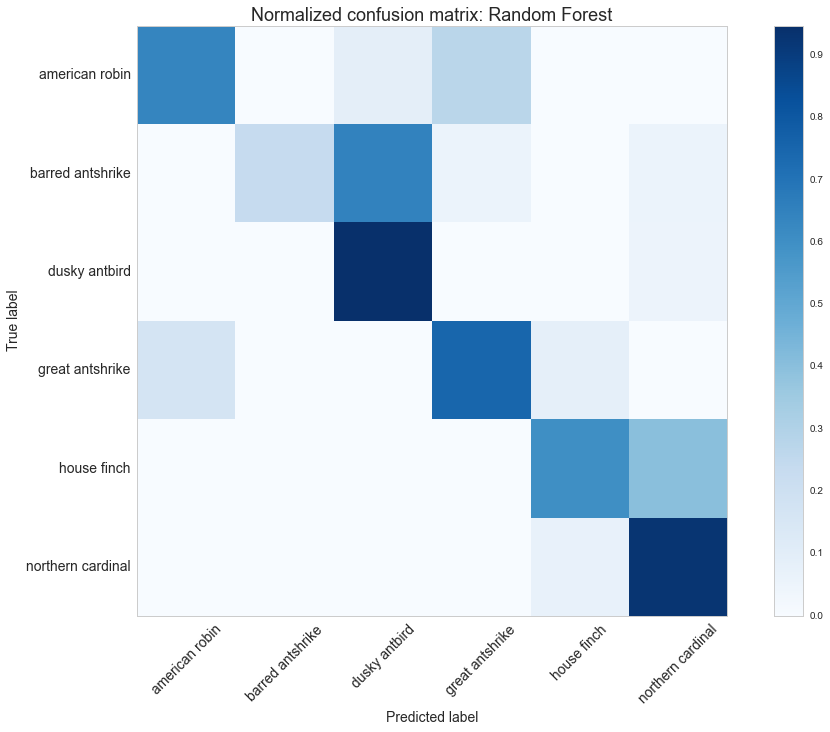

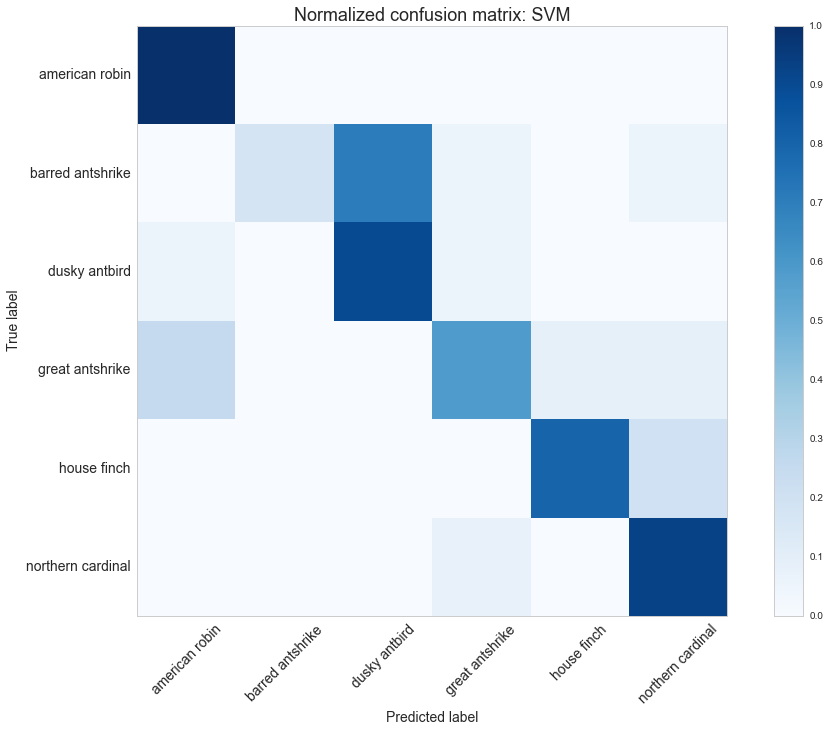

In [44]:
plt.figure(figsize=(14, 10))
plot_confusion_matrix(normalize_cm(cm), title='Normalized confusion matrix: Random Forest')

plt.figure(figsize=(14, 10))
plot_confusion_matrix(normalize_cm(cm_svm), title='Normalized confusion matrix: SVM')
plt.show()

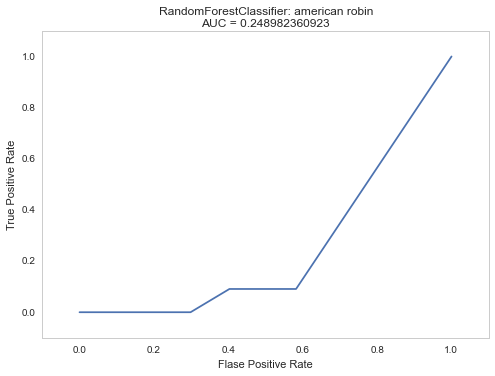

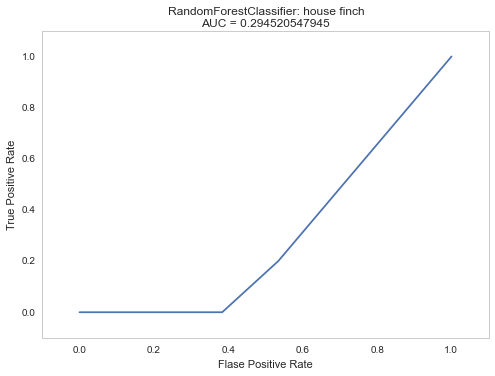

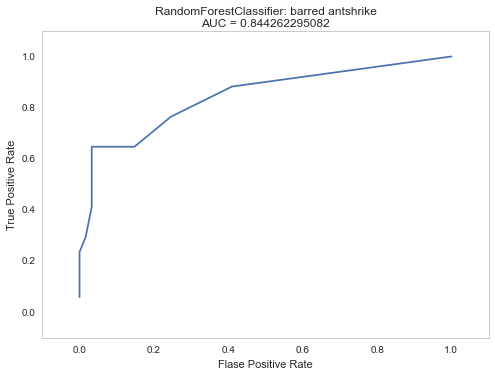

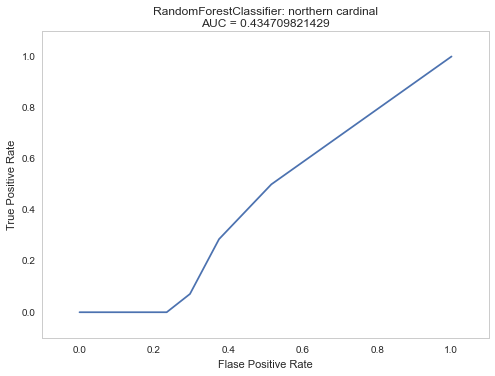

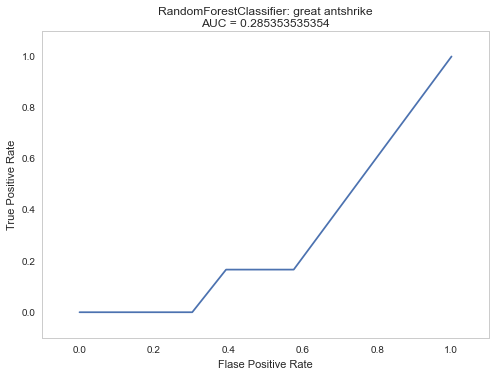

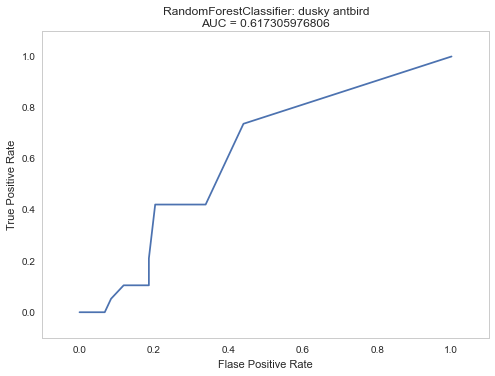

In [45]:
# plot ROC
for bird in df_allbirds['bird'].unique():
    pred = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred[:,1], pos_label=bird)
    auc_scr = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(str(clf).split('(')[0] + ': '+ bird + '\nAUC = {}'.format(auc_scr))
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])

# PCA

- use pca to plot the linearly seperable data on the graph

In [46]:
X = df_allbirds[df_allbirds.columns[2:]]
y = df_allbirds['bird']

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [49]:
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

[ 0.90652121  0.09246471]
0.998985920958


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, 
                                   random_state=4)

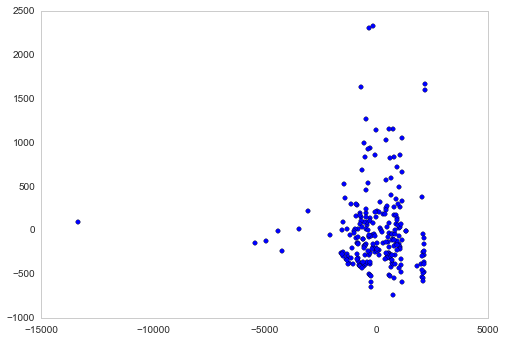

In [51]:
plt.scatter(X_pca[:,0], X_pca[:,1])